### Analysis and plotting of structural networks from Tractflow output

In [17]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

In [18]:
def find_network_label(node, networks):
    '''
    find the network that appears the node's name
    node is a string containing a node's name
    networks is a list of networks names
    '''
    for network in networks:
        if network in node:
            return network
    return None

def segment_FC(FC, nodes, networks):
    '''
    average FC values over each large network in
    networks
    the output FC matrix will be in the same order as 
    networks
    '''
    segmented = np.zeros((len(networks), len(networks)))
    counts = np.zeros((len(networks), len(networks)))
    for i, node_i in enumerate(nodes):
        network_i = networks.index(find_network_label(node_i, networks))
        for j, node_j in enumerate(nodes):
            network_j = networks.index(find_network_label(node_j, networks))
            segmented[network_i, network_j] += FC[i, j]
            counts[network_i, network_j] += 1
    return np.divide(segmented, counts, out=np.zeros_like(segmented), where=counts!=0) 

In [27]:
dataset = "qpn"
current_release = "Oct_2024" #"Jan_2024"
fmriprep_version = "v23.1.3"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}"
tabular_dir = f"{release_dir}/tabular/"

derivatives_dir = f"{dataset_dir}/derivatives/"
proc_dir = f"{release_dir}/proc/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# fmriprep extractions
fmriprep_extract_dir = f"{derivatives_dir}/fmriprep/{fmriprep_version}/IDP/FC/output/"

# network defs
tractoflow_dir = f"{derivatives_dir}/tractoflow/v1.5.0/"
network_def_dir = f"{tractoflow_dir}/networks/"

# Figures
figs_dir = f"{dataset_dir}/results/{session}/func/figs/"
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Load data

In [28]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

all_participants = list(control_participants) + list(PD_participants)

print(f"PD + control: {len(all_participants)}")
print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

PD + control: 263
Control: 69
PD: 194


,participant_id,redcap_event_name,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,"Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",diagnosis_group_for_analysis,diagnosis_age
0,MNI0028,Baseline (Arm 1: C-OPN),Unsure / Incertain,Uncertain / Incertain,NaN,unknown,55.85
1,MNI0056,Baseline (Arm 1: C-OPN),Yes / Oui,Meets exclusion criteria / Rencontre des critè...,0.0,unknown,75.28
2,MNI0058,Baseline (Arm 1: C-OPN),Yes / Oui,Uncertain / Incertain,0.0,unknown,56.19
3,MNI0068,Baseline (Arm 1: C-OPN),NaN,NaN,0.0,PD,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),Yes / Oui,Meets criteria for Parkinson's disease / Répon...,0.0,PD,46.02


### Network defs

In [29]:
# Network regions
space = "MNI152NLin2009cAsym_res-2"
parcels = 100
atlas = "Schaefer2018"
desc = f"{parcels}Parcels7Networks"

network_regions = f"{network_def_dir}/atlas-{atlas}_desc-{desc}_dseg.tsv"

network_regions_df = pd.read_csv(network_regions, sep="\t")
print(f"network_regions_df.shape: {network_regions_df.shape}")
network_regions_df[["n_regions", "hemi", "network", "network_index"]] = network_regions_df["name"].str.split("_",n=3,expand=True)
network_regions_df.head()

network_regions_df.shape: (100, 3)


,index,name,color,n_regions,hemi,network,network_index
0,1,7Networks_LH_Vis_1,#781283,7Networks,LH,Vis,1
1,2,7Networks_LH_Vis_2,#781284,7Networks,LH,Vis,2
2,3,7Networks_LH_Vis_3,#781285,7Networks,LH,Vis,3
3,4,7Networks_LH_Vis_4,#781287,7Networks,LH,Vis,4
4,5,7Networks_LH_Vis_5,#781288,7Networks,LH,Vis,5


In [30]:
session = "ses-01"
metric = 'correlation' # correlation , covariance , precision 
YEO_networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont','Default']

# participant_id = "sub-PD00020"
PD_network_df_list = []
HC_network_df_list = []
missing_participants = []
for participant_id in all_participants:
    bids_id = f"sub-{participant_id}"
    participant_FC_dir = f"{fmriprep_extract_dir}/sub-{participant_id}/{session}/"
    participant_FC_npy = f"{participant_FC_dir}/sub-{participant_id}_{session}_task-rest_space-{space}_FC_schaefer_{parcels}.npy"

    try:
        FC = np.load(participant_FC_npy, allow_pickle=True).item()
        roi_labels = FC['roi_labels']
        roi_labels = [str(label) for label in roi_labels]
        roi_labels = [label[label.find('Networks')+9:-3] for label in roi_labels]
        segmented_FC = segment_FC(FC[metric], nodes=roi_labels, networks=YEO_networks)
        FC_connectome = FC[metric]
        # network_df = pd.DataFrame(FC_connectome, columns=roi_labels, index=roi_labels)

    except FileNotFoundError:
        missing_participants.append(participant_id)
        print(f"File not found: {participant_FC_npy}")
        continue


    if participant_id in PD_participants:
        PD_network_df_list.append(FC_connectome)
    elif participant_id in control_participants:
        HC_network_df_list.append(FC_connectome)
    else:
        print(f"Participant {participant_id} not in PD or HC group")

n_available_PD = len(PD_network_df_list)
n_available_HC = len(HC_network_df_list)
print(f"n available PD: {n_available_PD}, n available HC: {n_available_HC}")
print(f"n missing participants: {len(missing_participants)}")


File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0224/ses-01//sub-MNI0224_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0326/ses-01//sub-MNI0326_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0350/ses-01//sub-MNI0350_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0426/ses-01//sub-MNI0426_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-PD01383/ses-01//sub-PD01383_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy


In [31]:
missing_participants_df = pd.DataFrame(missing_participants, columns=["participant_id"])
missing_participants_df.to_csv(f"{proc_dir}/hpc_job_list_fmriprep_ses-01_resubmit.txt", index=False, header=None)

### Aggregate and thrshold group networks

In [32]:
threshold_network = "None" #"binarize" #"clip" # for visualization purpose only

threshold_dict = { 
    "100Parcels7Networks" : {
        "binarize": 100,
        "lower_bound": 100,
        "upper_bound": 4000
    },
    "1000Parcels7Networks" : {
        "binarize": 10,
        "lower_bound": 2,
        "upper_bound": 50
    }
}

PD_network_df = np.stack(PD_network_df_list,axis=2).mean(axis=2)
HC_network_df = np.stack(HC_network_df_list,axis=2).mean(axis=2)

# sanity checks
PD_avg_connectivity = PD_network_df.mean().round(3)
HC_avg_connectivity = HC_network_df.mean().round(3)
print("-"*50)
print(f"n_PD: {n_available_PD}, PD_avg_connectivity: {PD_avg_connectivity}")
print(f"n_HC: {n_available_HC}, HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)

if threshold_network == "binarize":
    print("Binarizing")
    thrshold = threshold_dict[desc]["binarize"]
    PD_network_df = (PD_network_df > thrshold).astype(int)
    HC_network_df = (HC_network_df > thrshold).astype(int)

elif threshold_network == "remove_outliers":
    print("Removing outliers")
    lower_bound = threshold_dict[desc]["lower_bound"]
    upper_bound = threshold_dict[desc]["upper_bound"]
    PD_network_df[(PD_network_df < lower_bound)] = 0
    PD_network_df[(PD_network_df > upper_bound)] = upper_bound
    HC_network_df[(HC_network_df < lower_bound)] = 0
    HC_network_df[(HC_network_df > upper_bound)] = upper_bound
else:
    print("No thresholding applied")

# sanity checks
PD_avg_connectivity = PD_network_df.mean().round(3)
HC_avg_connectivity = HC_network_df.mean().round(3)
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)
print(f"PD_network_df.shape: {PD_network_df.shape}")
print(f"HC_network_df.shape: {HC_network_df.shape}")

--------------------------------------------------
n_PD: 187, PD_avg_connectivity: 0.209
n_HC: 64, HC_avg_connectivity: 0.267
--------------------------------------------------
No thresholding applied
--------------------------------------------------
PD_avg_connectivity: 0.209
HC_avg_connectivity: 0.267
--------------------------------------------------
PD_network_df.shape: (100, 100)
HC_network_df.shape: (100, 100)


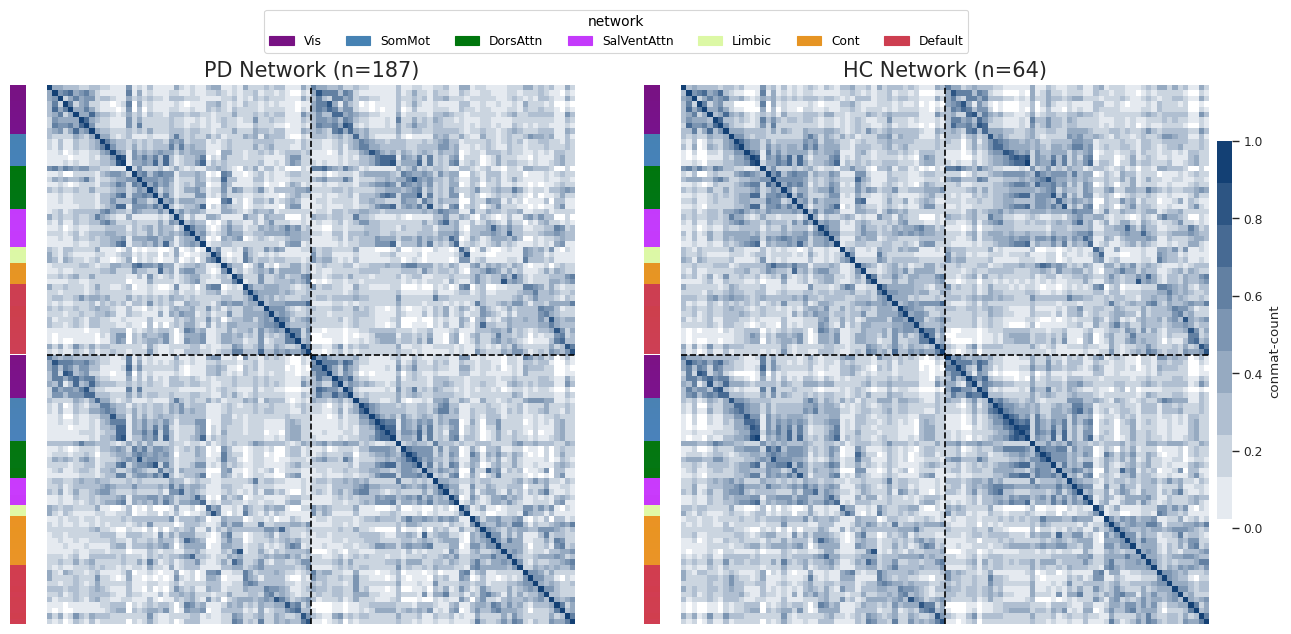

In [33]:
save_fig = True

n_color_bins = 10
max_color = '#134074'

cmap = LinearSegmentedColormap.from_list('', ['white', max_color], n_color_bins)

row_colors = network_regions_df["color"]

legend_TN = [mpatches.Patch(color=c, label=l) for c,l in network_regions_df[['color','network']].drop_duplicates("network").values]
midline_idx = PD_network_df.shape[0]//2

with sns.axes_style("white"):
    sns.set_context("paper")
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15, 7))
    cbar_ax = fig.add_axes([.905, .2, .01, .6])

    # -------------------------------------------------------------------------------------#
    # PD
    # -------------------------------------------------------------------------------------#
    plot_df = PD_network_df.copy()
    ax = axes[0]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, cbar=False) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"PD Network (n={n_available_PD})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')
   
    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))

    # -------------------------------------------------------------------------------------#
    # HC
    # -------------------------------------------------------------------------------------#
    plot_df = HC_network_df.copy()
    ax = axes[1]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, 
                    cbar_kws= {'label': 'conmat-count'},cbar_ax=cbar_ax) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"HC Network (n={n_available_HC})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')

    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))
    
l2=g.legend(loc='center left',bbox_to_anchor=(-0.8,1.1),ncol=7, handles=legend_TN,frameon=True) #(1.01,0.9)
l2.set_title(title='network',prop={'size':10})
# plt.tight_layout()

if save_fig:
    plt.savefig(f"{figs_dir}/{atlas}_{desc}.png")